## Governing Equation: 
$$
\dfrac{d^2 x}{d t^2} + \omega_0^2x^3 = 0
$$

In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def derivative(y,t):
    return torch.autograd.grad(
        y,t,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True
    )[0]

In [20]:
class Sin(nn.Module):
    def forward(self,x):
        return torch.sin(x)

In [21]:
#Model
class PINN(nn.Module):
    def __init__(self,hidden_dim=32,hidden_layers=5):
        super(PINN, self).__init__()
        layers=[]
        layers.append(nn.Linear(1,hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim,hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim,1))
        self.net=nn.Sequential(*layers)
    def forward(self,t):
        return self.net(t)

In [22]:
#True_solution
# def true_solution(t,x0=1.0,v0=0.0,omega=2.0):
#     return x0*np.cos(omega*t) #+(v0/omega)*np.sin(omega*t)
w0=3
x0,v0=1.0,0.0
t_min,t_max=0.0,3.0
device=torch.device("cpu")

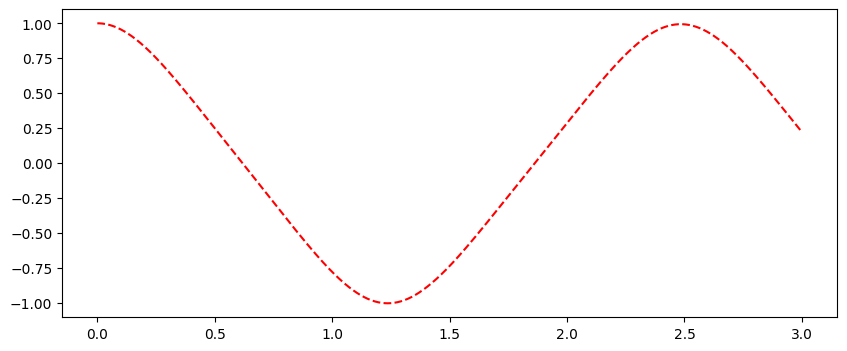

In [23]:
from scipy.integrate import solve_ivp
def spring_rhs(t, y, w0):
    return [y[1], -w0**2 * (y[0]**3)]

# x0, v0 = 0.1, 40.0
t_span = (0, 3.0)
t_dense = np.linspace(*t_span, 1001)

sol = solve_ivp(spring_rhs, t_span, [x0, v0], t_eval=t_dense, args=(w0,))
plt.figure(figsize=(10,4))
#plt.plot(t_test.detach(),x_true,'k-',label="True_Solution")
plt.plot(t_dense,sol.y[0],'r--',label="Actual_Solution")

In [24]:
#Noisy_Data_generation
np.random.seed(0)
torch.manual_seed(123)
# N_data=50
# t_data_np=np.linspace(t_min,t_max,N_data)
# x_exact=true_solution(t_data_np,x0,v0,omega)
# noise=0.9*np.random.randn(*x_exact.shape)
# x_noisy=x_exact+noise
# t_data=torch.tensor(t_data_np.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
# x_data=torch.tensor(x_noisy.reshape(-1, 1), dtype=torch.float32)

#Collocation_Points
N_f=1000
t_f=torch.linspace(t_min, t_max, N_f).view(-1, 1).requires_grad_(True)
#Boundary_Points
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

In [25]:
# torch.manual_seed(123)
# t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
# t_physics = torch.linspace(0,2,100).view(-1,1).requires_grad_(True)
# N_data=50
# t_data_np=np.linspace(t_min,t_max,N_data)
# x_exact=true_solution(t_data_np,x0,v0,omega)
# noise=0.9*np.random.randn(*x_exact.shape)
# x_noisy=x_exact+noise

# t_data=torch.tensor(t_data_np.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
# x_data=torch.tensor(x_noisy.reshape(-1, 1), dtype=torch.float32)

# N_f=1000
# t_f=torch.linspace(t_min, t_max, N_f).view(-1, 1).requires_grad_(True)

In [26]:
model=PINN()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
def loss_fn():
    # u = model(t_boundary)
    # loss1 = (torch.squeeze(u) - 1)**2
    # dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    # loss2 = (torch.squeeze(dudt) - 0)**2
    # u = model(t_physics)
    # dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    # d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    # loss3 = torch.mean((d2udt2)**2)
    #Data_loss
    # x_pred_data=model(t_data)
    # loss_data=torch.mean((x_pred_data - x_data)**2)
    #Boundary_Loss
    x_pred_b=model(t_boundary)
    loss_b1=(torch.squeeze(x_pred_b) - x0)**2
    dx_dt_b=torch.autograd.grad(x_pred_b, t_boundary, torch.ones_like(x_pred_b), create_graph=True)[0]
    loss_b2=(torch.squeeze(dx_dt_b) - v0)**2

    #Physics_loss
    x_pred_f=model(t_f)
    dx_dt_f=derivative(x_pred_f, t_f)
    d2x_dt2_f=derivative(dx_dt_f, t_f)
    residual=d2x_dt2_f + w0**2 * x_pred_f**3
    loss_phys=torch.mean(residual**2)

    return loss_b1+loss_b2 + loss_phys, loss_b1.item(),loss_b2.item(), loss_phys.item()



In [27]:
losses,boundary1_losses,boundary2_losses,phys_losses=[],[],[],[]
for epoch in range(40001):
    optimizer.zero_grad()
    loss, l_b1,l_b2, l_phys=loss_fn()
    loss.backward()
    optimizer.step()
    if epoch%4000==0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.2e}, Boundary_1: {l_b1:.2e}, Boundary_2: {l_b2:.2e}, Phys: {l_phys:.2e}")
        losses.append(loss.item())
        boundary1_losses.append(l_b1)
        boundary2_losses.append(l_b2)
        phys_losses.append(l_phys)



Epoch 0, Total Loss: 1.10e+00, Boundary_1: 1.10e+00, Boundary_2: 5.77e-04, Phys: 9.02e-05
Epoch 4000, Total Loss: 7.04e-02, Boundary_1: 4.80e-02, Boundary_2: 1.57e-04, Phys: 2.22e-02
Epoch 8000, Total Loss: 5.84e-03, Boundary_1: 2.87e-03, Boundary_2: 1.47e-05, Phys: 2.95e-03
Epoch 12000, Total Loss: 1.78e-04, Boundary_1: 6.59e-05, Boundary_2: 3.22e-10, Phys: 1.12e-04
Epoch 16000, Total Loss: 9.79e-05, Boundary_1: 2.35e-05, Boundary_2: 7.56e-09, Phys: 7.44e-05
Epoch 20000, Total Loss: 1.62e-02, Boundary_1: 5.52e-08, Boundary_2: 4.81e-05, Phys: 1.61e-02
Epoch 24000, Total Loss: 3.58e-03, Boundary_1: 3.02e-05, Boundary_2: 3.45e-06, Phys: 3.54e-03
Epoch 28000, Total Loss: 5.65e-05, Boundary_1: 1.26e-05, Boundary_2: 4.21e-08, Phys: 4.39e-05
Epoch 32000, Total Loss: 3.47e-04, Boundary_1: 8.73e-06, Boundary_2: 2.30e-07, Phys: 3.39e-04
Epoch 36000, Total Loss: 1.96e-04, Boundary_1: 1.10e-05, Boundary_2: 3.37e-08, Phys: 1.84e-04
Epoch 40000, Total Loss: 1.15e-02, Boundary_1: 6.14e-05, Boundary_

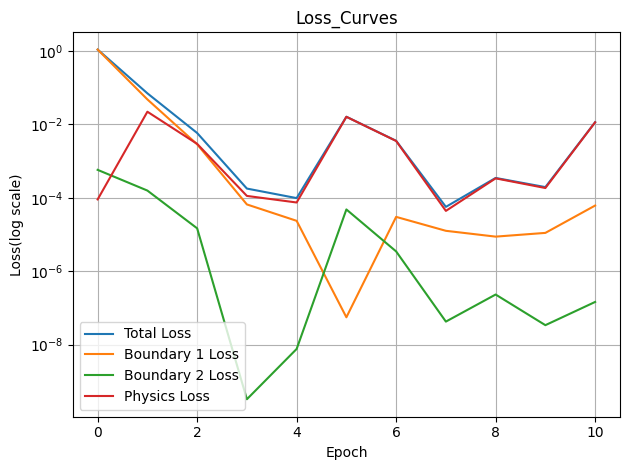

In [28]:
plt.plot(np.array(losses),label="Total Loss")
plt.plot(np.array(boundary1_losses),label="Boundary 1 Loss")
plt.plot(np.array(boundary2_losses),label="Boundary 2 Loss")
plt.plot(np.array(phys_losses),label="Physics Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss(log scale)")
plt.title("Loss_Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

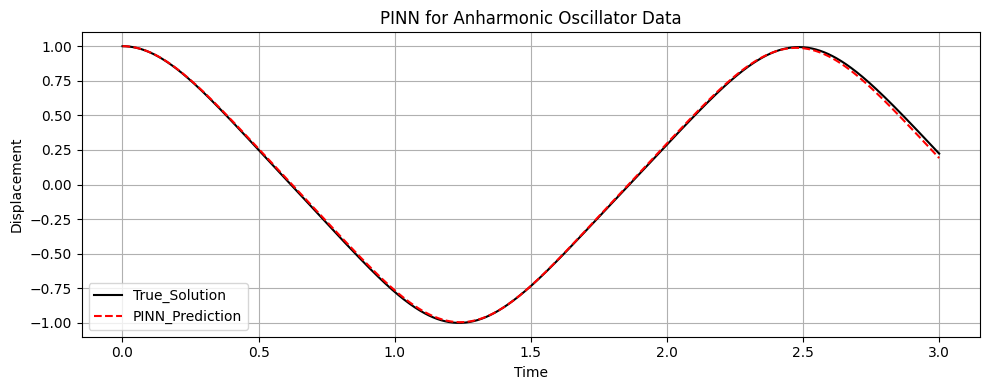

In [29]:
#Evaluation
t_test = torch.linspace(t_min, t_max, 200).view(-1,1).requires_grad_(True)
x_pred = model(t_test).detach().numpy()
#x_true = true_solution(t_test.detach().numpy().flatten(), x0, v0, omega)

plt.figure(figsize=(10,4))
plt.plot(t_dense,sol.y[0],'k-',label="True_Solution")
plt.plot(t_test.detach(),x_pred,'r--',label="PINN_Prediction")
#plt.scatter(t_data.detach(),x_data.detach(),c='blue',label="Noisy_Data_Points",s=30,alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.title("PINN for Anharmonic Oscillator Data")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# from scipy.integrate import solve_ivp
# def spring_rhs(t, y, omega):
#     return [y[1], -omega**2 * np.sin(y[0])]

# omega = 25.0
# x0, v0 = 0.1, 40.0
# t_span = (0, 5*np.pi/omega)
# t_dense = np.linspace(*t_span, 1001)

# sol = solve_ivp(spring_rhs, t_span, [x0, v0], t_eval=t_dense, args=(omega,))
# plt.figure(figsize=(10,4))
# #plt.plot(t_test.detach(),x_true,'k-',label="True_Solution")
# plt.plot(t_dense,sol.y[0],'r--',label="Actual_Solution")


In [31]:
import deepxde as dde
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Compiling model...
Building feed-forward neural network...
'build' took 0.138708 s

'compile' took 1.034456 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.07e-02, 1.00e+00, 3.81e-02, 4.97e-01]    [1.07e-02, 1.00e+00, 3.81e-02, 4.97e-01]    []  
1000      [1.73e-01, 1.61e-01, 2.65e-04, 3.86e-01]    [1.73e-01, 1.61e-01, 2.65e-04, 3.86e-01]    []  
2000      [1.68e-01, 1.65e-01, 2.06e-03, 3.82e-01]    [1.68e-01, 1.65e-01, 2.06e-03, 3.82e-01]    []  
3000      [1.68e-01, 1.65e-01, 2.07e-03, 3.82e-01]    [1.68e-01, 1.65e-01, 2.07e-03, 3.82e-01]    []  
4000      [1.68e-01, 1.65e-01, 2.11e-03, 3.82e-01]    [1.68e-01, 1.65e-01, 2.11e-03, 3.82e-01]    []  
5000      [1.68e-01, 1.65e-01, 2.10e-03, 3.82e-01]    [1.68e-01, 1.65e-01, 2.10e-03, 3.82e-01]    []  
6000      [1.68e-01, 1.64e-01, 2.27e-03, 3.82e-01]    [1.68e-01, 1.64e-01, 2.27e-03, 3.82e-01]    []  
7000      [1.67e-01, 1.64e-01, 2.66e-03

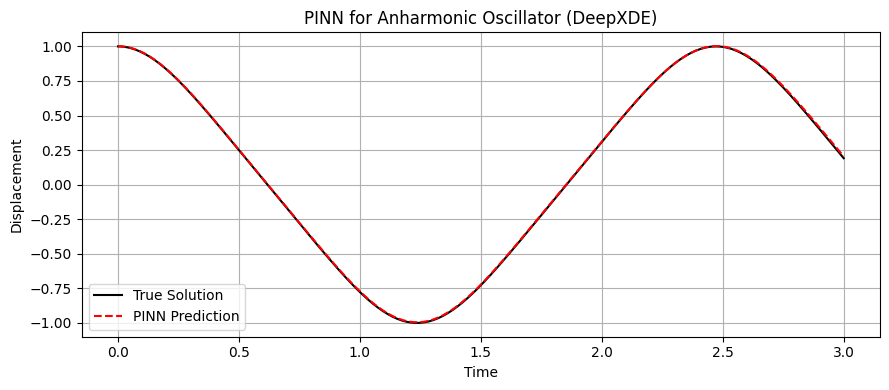

In [32]:
omega=3
# 1. Define the Van der Pol ODE system
def VDP(y, t):
    x, dx = y
    d2x =-(omega**2)*(x**3)
    return [dx, d2x]

# 2. Generate reference data using Scipy's odeint
t = np.linspace(0, 3, 300)
y0 = [1.0, 0.0]  # Initial condition: x(0) = 1, dx/dt(0) = 0
y = odeint(VDP, y0, t)

# 3. Prepare training data: only x(t), not dx/dt
t_data = t.reshape(-1, 1)
y_data = y[:, 0:1]  # Only x(t), not dx/dt

# 4. Define PDE residual: f = d2x/dt2 - mu*(1 - x^2)*dx/dt + x = 0
def VDP_pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=0)      # dx/dt
    d2y_tt = dde.grad.hessian(y, x, component=0)  # d2x/dt2
    # mu = 5.0
    return d2y_tt+(omega**2)*(y**3)

# 5. Define geometry
geom = dde.geometry.TimeDomain(0.0, 3.0)

# 6. Define initial condition x(0) = 1
ic1 = dde.icbc.IC(geom, lambda x: 1.0, lambda _, on_initial: on_initial)

# 7. Define derivative condition dx/dt(0) = 0 using OperatorBC
def boundary(t, on_boundary):
    return on_boundary and dde.utils.isclose(t[0], 0)

def derivative_operator(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=0)  # dx/dt

ic2 = dde.icbc.OperatorBC(geom, derivative_operator, boundary)

# 8. Data-driven component (optional): include exact sampled solution
t_y_data = dde.PointSetBC(t_data, y_data)

# 9. Build data object
data = dde.data.TimePDE(
    geom, VDP_pde, [ic1, ic2, t_y_data], num_domain=40, num_boundary=1
)

# 10. Define neural network (FNN with 3 hidden layers of 32 neurons)
net = dde.maps.FNN([1] + [32] * 5 + [1], "tanh", "Glorot uniform")

# 11. Build and train the model
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=52000)

# 12. Plot prediction vs true
y_pred = model.predict(t_data)

plt.figure(figsize=(9,4))
plt.plot(t, y[:,0], "k-", label="True Solution")
plt.plot(t, y_pred, "r--", label="PINN Prediction")
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.title("PINN for Anharmonic Oscillator (DeepXDE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()